In [1]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from rasp_models.fractok import check_fractok
from tracr.haiku_to_pytorch import haiku_to_pytorch


from datasets.dataloaders import makeFractokDataLoader
from torchinfo import summary

In [2]:
loader = makeFractokDataLoader()

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = check_fractok()
torch_model = haiku_to_pytorch(model).to(DEVICE)

In [4]:
def evaluate(model, batch):
    inputs, outputs = batch[0]  # Unpack from batch
    
    # inputs is already a list of strings like ['BOS', 'd', 'x', 'c', 'e']
    # The model expects this format directly
    
    outputs = outputs.to(DEVICE)
    
    model_output = model.forward(inputs)  # Pass strings directly

    if not model_output.is_cuda and DEVICE == "cuda":
        model_output = model_output.to(DEVICE)

    # if torch.isnan(sum(sum(sum(model_output)))):
    #     print(inputs)
    #     print(outputs)
    #     print(model_output)

    # print("Debug info:")
    # print(inputs[0], outputs[0], model_output[0])
    loss = F.mse_loss(model_output, outputs) * 1000
    # loss = F.cross_entropy(model_output, outputs)

    return loss, {
        "logits": model_output
    }

In [5]:
summary(torch_model)

Layer (type:depth-idx)                   Param #
TracrTransformer                         --
├─ModuleList: 1-1                        --
│    └─TracrBlock: 2-1                   --
│    │    └─TracrAttention: 3-1          1,457
│    │    └─TracrMLP: 3-2                88
│    └─TracrBlock: 2-2                   --
│    │    └─TracrAttention: 3-3          1,457
│    │    └─TracrMLP: 3-4                88
Total params: 3,090
Trainable params: 3,090
Non-trainable params: 0

In [6]:
for name, param in torch_model.named_parameters():
    print(name, param.data)

layers.0.attn.query.weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.,

In [7]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=1,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.

2.09


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.92it/s]


1.8


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.45it/s]


1.9


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 91.52it/s]


1.75


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.09it/s]


1.96


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.74it/s]


2.11


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 82.13it/s]


1.87


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.55it/s]


2.21


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 83.81it/s]

2.28


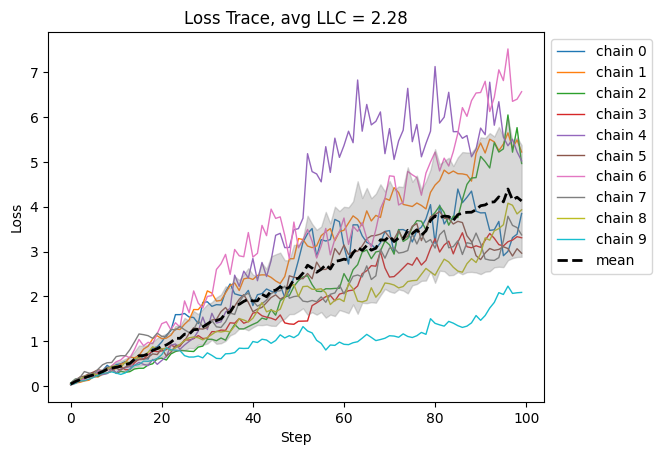

<Figure size 1200x900 with 0 Axes>

In [8]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [9]:
for name, param in torch_model.layers[0].mlp.linear2.named_parameters():
    print(name, param.data)

weight tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64)
bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=torch.float64)


In [10]:
initial_output = torch_model(['BOS', 'a', 'x', 'b', 'x'])
print(initial_output)

tensor([[[1.0778e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.8080e-13, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.0000e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0000e+00, 1.0000e+

In [11]:
with torch.no_grad():   
    torch_model.layers[0].mlp.linear2.weight.copy_(torch.zeros_like(torch_model.layers[0].mlp.linear2.weight.data))

In [12]:
for name, param in torch_model.layers[0].mlp.linear2.named_parameters():
    print(name, param.data)

weight tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=torch.float64)
bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], dtype=torch.float64)


In [14]:
ablated_output = torch_model(['BOS', 'a', 'x', 'b', 'x'])
print(ablated_output)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [15]:
print(initial_output.equal(ablated_output))

False


In [15]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=1,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.

2.11


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.49it/s]


2.15


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.57it/s]


2.05


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 84.09it/s]


2.07


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 88.85it/s]


1.78


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.17it/s]


2.0


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 85.99it/s]


2.1


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.62it/s]


1.98


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 84.59it/s]

1.91


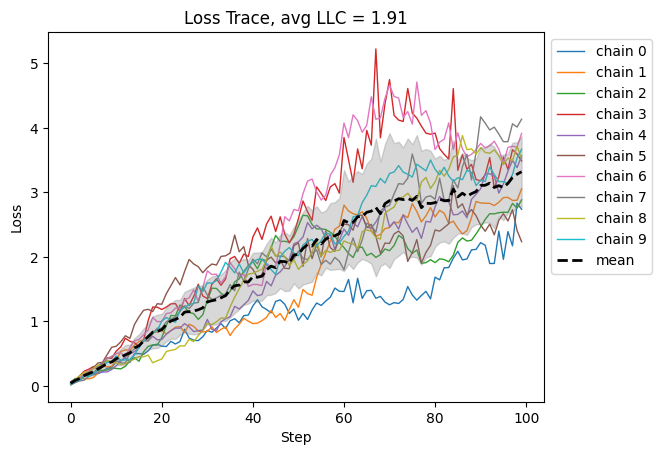

<Figure size 1200x900 with 0 Axes>

In [16]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [16]:
for name, param in torch_model.layers[0].mlp.linear1.named_parameters():
    print(name, param.data)

weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
bias tensor([0.], dtype=torch.float64)


In [17]:
with torch.no_grad():   
    torch_model.layers[0].mlp.linear1.weight.copy_(torch.zeros_like(torch_model.layers[0].mlp.linear1.weight.data))

In [18]:
for name, param in torch_model.layers[0].mlp.linear1.named_parameters():
    print(name, param.data)

weight tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]], dtype=torch.float64)
bias tensor([0.], dtype=torch.float64)


In [19]:
twice_ablated_output = torch_model(['BOS', 'a', 'x', 'b', 'x'])
print(twice_ablated_output)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [20]:
print(ablated_output.equal(twice_ablated_output))

True


In [22]:
with torch.no_grad():
    for _, param in torch_model.named_parameters():
        param.copy_(torch.zeros_like(param.data))

In [23]:
fully_ablated_output = torch_model(['BOS', 'a', 'x', 'b', 'x'])
print(fully_ablated_output)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]],
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [26]:
for name, param in torch_model.named_parameters():
    print(name, param)

layers.0.attn.query.weight Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
      

In [25]:
print(ablated_output.equal(fully_ablated_output))

True


In [27]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=1,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.

1.91


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.47it/s]


1.7


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.63it/s]


1.82


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 91.41it/s]


2.02


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 84.20it/s]


1.75


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 89.97it/s]


1.97


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.34it/s]


1.66


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 91.12it/s]


1.9


Chain 9: 100%|██████████| 101/101 [00:01<00:00, 90.53it/s]

1.88


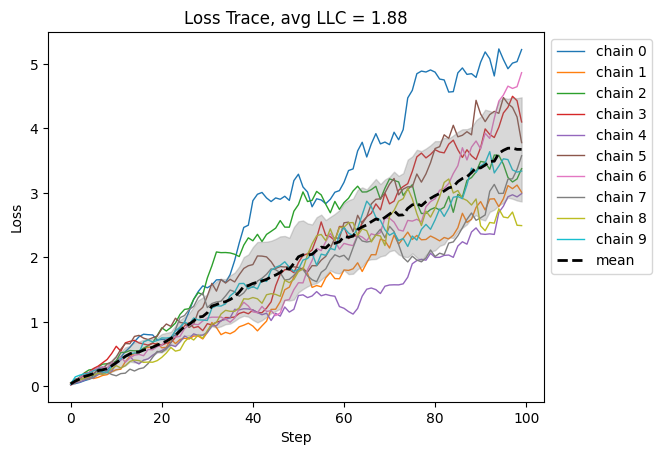

<Figure size 1200x900 with 0 Axes>

In [28]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [29]:
def zero_output_hook(module, input, output):
    # Return a zeroed tensor with the same shape/device/dtype
    return torch.zeros_like(output)

handle = torch_model.layers[1].register_forward_hook(zero_output_hook)

In [30]:
torch_model(['BOS', 'a', 'x', 'b', 'x'])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], dtype=torch.float64)

In [31]:
for _ in range(9):
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        torch_model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=1e-5, localization=1.0, nbeta=default_nbeta(loader)),
        num_chains=10,  # How many independent chains to run
        num_draws=100,  # How many samples to draw per chain
        num_burnin_steps=1,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=1,  # How many steps to take between each sample
        device=DEVICE,
        online=True,
    )
    trace = learning_coeff_stats["loss/trace"]
    print(round(sum(learning_coeff_stats['llc/means'])/len(learning_coeff_stats['llc/means']), 2))

/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/aybarskocoglu/llc-interpretability/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn